In [16]:
import pandas as pd
import numpy as np
import pickle
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline

warnings.filterwarnings('ignore')

#model
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller

In [133]:
stock_df = pd.read_csv('./005930.KS.csv', sep=',', index_col='Date')
stock_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284
...,...,...,...,...,...,...
2021-05-12,80800.0,81200.0,79800.0,80000.0,80000.000000,35812268
2021-05-13,78900.0,79600.0,78400.0,78500.0,78500.000000,31490096
2021-05-14,79000.0,80300.0,78900.0,80100.0,80100.000000,16450920


<AxesSubplot: >

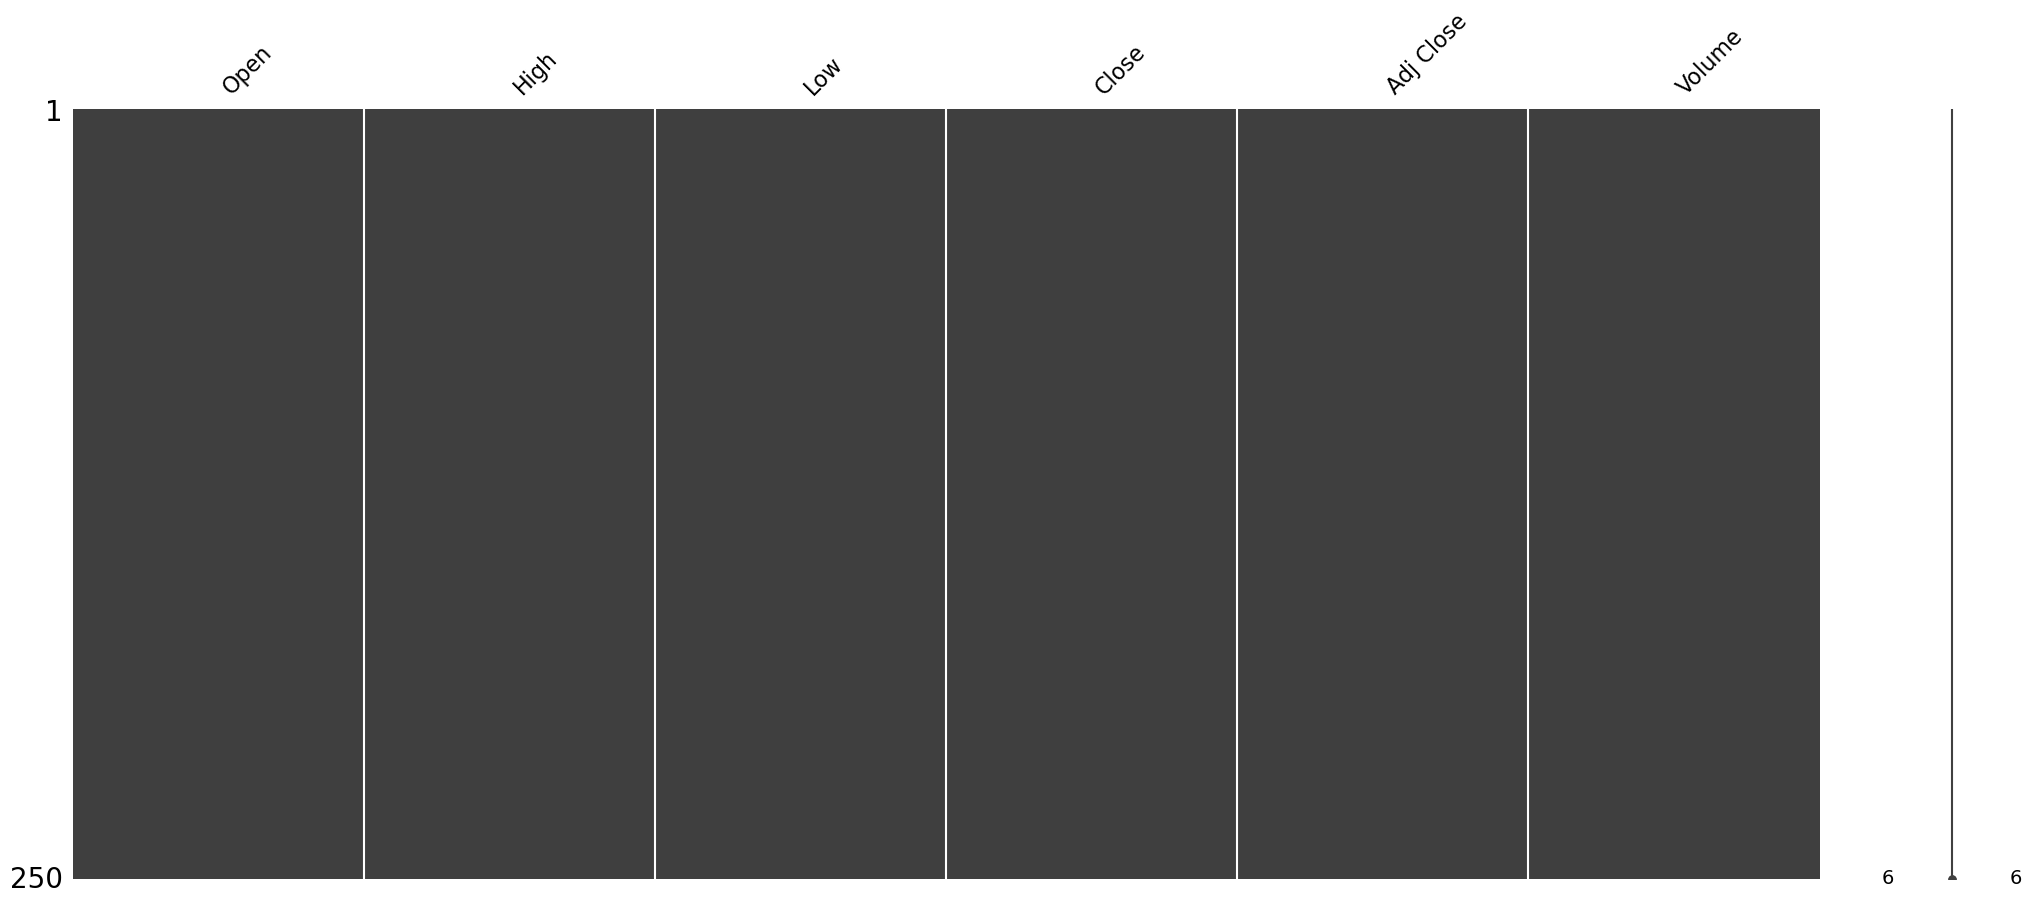

In [134]:
msno.matrix(stock_df)

In [139]:
#stock_df['Date'] = pd.to_datetime(stock_df['Date'])

In [140]:
stock_df.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)

In [141]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250 entries, 2020-05-18 to 2021-05-18
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Adj Close   250 non-null    float64
 1   Price_diff  249 non-null    float64
dtypes: float64(2)
memory usage: 5.9+ KB


In [142]:
def check_stationary(ts, alpha):
    print("Dickey Fuller Test ---")
    print("H0: non-stationary")
    print("H1: stationary")
    
    adft = adfuller(ts, autolag='AIC')
    
    if adft[1] < alpha:
        print(f"p-value: {alpha}, reject H0")
    else:
        print(f"p-value: {alpha}, Accept H0")

check_stationary(stock_df['Adj Close'], 0.05)


Dickey Fuller Test ---
H0: non-stationary
H1: stationary
p-value: 0.05, Accept H0


In [143]:
stock_df['Price_diff'] = stock_df["Adj Close"].diff()
stock_df.head()

,Adj Close,Price_diff
Date,,
2020-05-18,46788.835938,NaN
2020-05-19,48227.015625,1438.179687
2020-05-20,47939.382813,-287.632812
2020-05-21,47891.437500,-47.945313
2020-05-22,46740.894531,-1150.542969


In [144]:
stock_df.dropna(subset='Price_diff', inplace=True)

In [145]:
check_stationary(stock_df['Price_diff'], 0.05)

Dickey Fuller Test ---
H0: non-stationary
H1: stationary
p-value: 0.05, reject H0


# 모델 진단
- 잔차(Residual) = 실제값 - 예측값
- $e_t = y_t - \hat{y}_t$ 
-  $e_t \sim N(0, \sigma^2)$
 - 잔차는 정규분포를 띄며, 잔차의 평균은 0이고, 분산은 상수를 가짐
 - 잔차끼리 상관관계(correlation)가 없어야 함 

In [165]:
y_train = stock_df['Adj Close'][:int(0.7*len(stock_df))]
y_test = stock_df['Adj Close'][int(0.7*len(stock_df)):]

In [177]:
model_autoARIMA = auto_arima(
    y_train, 
    start_p=0, start_q=0,  # p, q 시작값
    max_p=3, max_q=3,      # p and q 최댓값
    test='adf',            # adf를 통해 d 계산
    d=1,                   # 모델을 통해 d 지정
    m=1,                   # 연(year)간 데이터
    seasonal=False,        # 계절성 없음
    trace=True,            # 값 보여줌
    with_intercept='auto', # 상수 자동으로 포함/비포함 결정
    stepwise=True          # p, q 조합으로 진행
)
model_autoARIMA.fit(y_train)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2945.030, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2947.022, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2947.005, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2948.537, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2949.000, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.098 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  174
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1470.515
Date:                Fri, 16 Dec 2022   AIC                           2945.030
Time:                        18:03:59   BIC                           2951.336
Sample:                             0   HQIC                          2947.588
                                - 174                                       

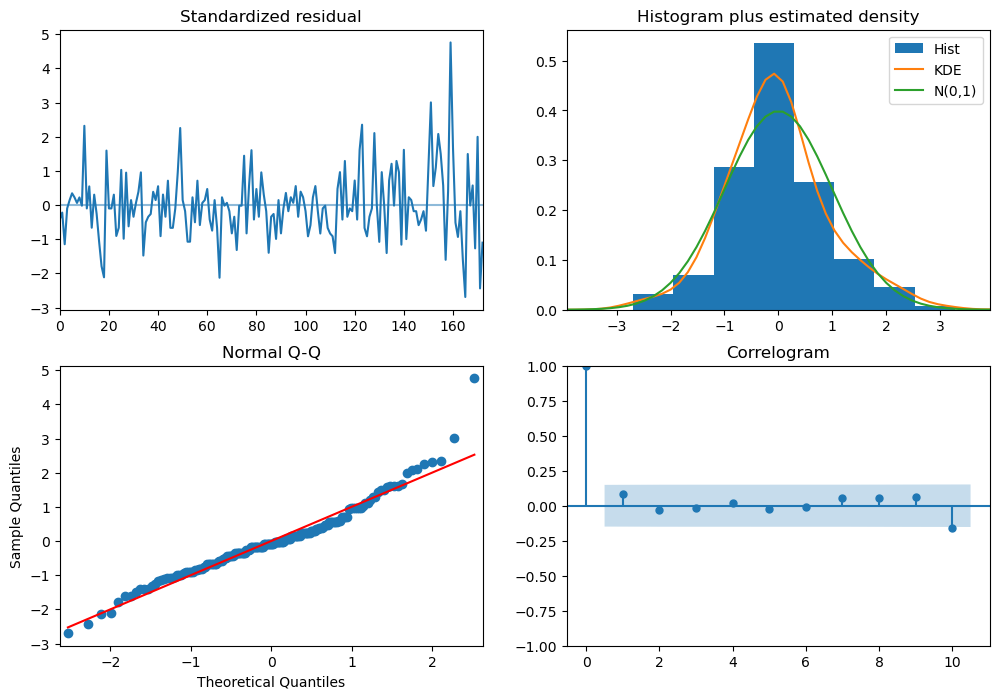

In [178]:
model_autoARIMA.plot_diagnostics(figsize=(12,8))
plt.show()

- **Standardized Residual Plot** (표준화 잔차): 잔차의 표준오차로 나누어 표준화(standardized)한 값을 그래프로 표현한 것으로 평균 0과 분산이 상수인지 확인
- **Histogram plus estimated density** (잔차의 히스토그램): 잔차가 평균 0을 가진 정규분포를 따르는지 확인 
- **Normal Q-Q** (정규 확률 그래프): 이론적 분포인 잔차가 정규분포를 따르는지 확인하는 그래프
- **Correlogram** (ACF plot): 잔차의 상관관계는 lag이 0을 제외하고 (0은 본인과 본인 값이므로 상관관계는 언제나 1) 상관관계 값이 0과 가까우므로 상관관계가 없음. 

In [179]:
y_pred = model_autoARIMA.predict(n_periods=len(y_test))
y_pred

174     85435.144509
175     85648.984330
176     85862.824152
177     86076.663973
178     86290.503794
           ...      
244    100403.931991
245    100617.771812
246    100831.611634
247    101045.451455
248    101259.291276
Length: 75, dtype: float64

In [180]:
def rmse(y, y_pred):
    return np.sqrt(np.mean(np.square(y - y_pred)))

In [181]:
rmse(result_df["y"], result_df["y_pred"])

4758.284522186361

In [182]:
def forecast_one_step():
    fc, conf_int = model_autoARIMA.predict(n_periods=1 # 한 스텝씩!
        , return_conf_int=True)              # 신뢰구간 출력
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )

In [183]:
forecasts = []
y_pred = []
pred_upper = []
pred_lower = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])

    ## 모형 업데이트 !!
    model_autoARIMA.update(new_ob)

In [184]:
pd.DataFrame({"test": y_test, "pred": y_pred})

,test,pred
Date,,
2021-01-28,83329.710938,85435.144509
2021-01-29,81637.226563,83540.358298
2021-02-01,82632.804688,81829.389694
2021-02-02,84026.609375,82824.967819
2021-02-03,84225.726563,84218.772506
...,...,...
2021-05-12,80000.000000,81344.994892
2021-05-13,78500.000000,80140.376574
2021-05-14,80100.000000,78635.751186


In [185]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = go.Figure([
    # 훈련 데이터-------------------------------------------------------
    go.Scatter(x = y_train.index, y = y_train, name = "Train", mode = 'lines'
              ,line=dict(color = 'royalblue'))
    # 테스트 데이터------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_test, name = "Test", mode = 'lines'
                ,line = dict(color = 'rgba(0,0,30,0.5)'))
    # 예측값-----------------------------------------------------------
    , go.Scatter(x = y_test.index, y = y_pred, name = "Prediction", mode = 'lines'
                     ,line = dict(color = 'red', dash = 'dot', width=3))
    
    # 신뢰 구간---------------------------------------------------------
    , go.Scatter(x = y_test.index.tolist() + y_test.index[::-1].tolist() 
                ,y = pred_upper + pred_lower[::-1] ## 상위 신뢰 구간 -> 하위 신뢰 구간 역순으로
                ,fill='toself'
                ,fillcolor='rgba(0,0,30,0.1)'
                ,line=dict(color='rgba(0,0,0,0)')
                ,hoverinfo="skip"
                ,showlegend=False)
])

fig.update_layout(height=400, width=1000, title_text="ARIMA(0,1,0)모형")
fig.show()

In [186]:
def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
    
print(f"MAPE: {MAPE(y_test, y_pred):.3f}")

MAPE: 1.049
